In [1]:
%load_ext autoreload
%autoreload 2

# Hyperdt install

In [2]:
# %%bash
# which python
# cd ~
# git clone https://github.com/qc2321/hyperDT # Quentin's updated version of hyperDT
# cd hyperDT
# pip install -e .

In [3]:
# %%bash
# pip install geomstats

# HyperDT benchmark - Gaussian mixtures

In [4]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import embedders

from tqdm.notebook import tqdm

from hyperdt.tree import HyperbolicDecisionTreeClassifier
from hyperdt.forest import ProductSpaceRF

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split

import warnings

# Filter out warnings raised when sampling Wishart distribution in Gaussian mixtures
warnings.filterwarnings("ignore", category=UserWarning)

INFO: Using numpy backend


In [5]:
if torch.backends.mps.is_available():
    device = "mps"
elif torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

sample_device = "cuda" if device == "cuda" else "cpu"

0.94
0.915


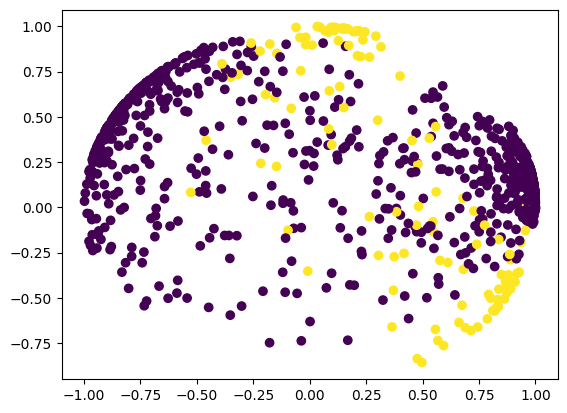

In [6]:
# Basic structure: let's do H2, but with a really high curvature

signature = [(-4, 2)]
pm = embedders.manifolds.ProductManifold(signature=signature)

X, y = embedders.gaussian_mixture.gaussian_mixture(pm=pm, seed=42, cov_scale_means=1.0, cov_scale_points=1.0)
X = X.detach().cpu().numpy()
y = y.detach().cpu().numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# hyperDT
hdt = HyperbolicDecisionTreeClassifier(max_depth=3, skip_hyperboloid_check=1)
hdt.fit(X_train, y_train)
print(hdt.score(X_test, y_test))

# sklearn
dt = DecisionTreeClassifier(max_depth=3)
dt.fit(X_train, y_train)
print(dt.score(X_test, y_test))

# Also let's visualize the points
X_poincare = embedders.visualization.hyperboloid_to_poincare(X)
plt.scatter(X_poincare[:, 0], X_poincare[:, 1], c=y)

In [11]:
# %%prun

results = []

CURVATURES = [-4, -2, -1, -0.5, -0.25, 0, 0.25, 0.5, 1, 2, 4]
DIM = 2
N_SAMPLES = 5
N_POINTS = 1_000
N_CLASSES = 8
N_CLUSTERS = 32
MAX_DEPTH = 5
COV_SCALE_MEANS = 1.0
COV_SCALE_POINTS = 0.1
# TASK = "regression"
TASK = "classification"
# MODELS = ["ps_perceptron"]
RESAMPLE_SCALES = False

SCORE = "f1-micro" if TASK == "classification" else "rmse"

with torch.no_grad():
    my_tqdm = tqdm(total=len(CURVATURES) * N_SAMPLES)
    for i, K in enumerate(CURVATURES):
        for seed in range(N_SAMPLES):
            # Ensure unique seed per trial
            seed = seed + N_SAMPLES * i
            pm = embedders.manifolds.ProductManifold(signature=[(K, DIM)], device=sample_device)

            # Get X, y
            X, y = embedders.gaussian_mixture.gaussian_mixture(
                pm=pm,
                seed=seed,
                num_points=N_POINTS,
                num_classes=N_CLASSES,
                num_clusters=N_CLUSTERS,
                cov_scale_means=1.0 / DIM,
                cov_scale_points=1.0 / DIM,
                task=TASK,
            )
            X = X.to(device)
            y = y.to(device)

            if RESAMPLE_SCALES:
                scale = 0.5 - np.random.rand() * 20
                pm.P[0].scale = torch.exp(torch.tensor(scale)).item()
                pm.P[0].manifold._log_scale = torch.nn.Parameter(torch.tensor(scale))

            # Benchmarks are now handled by the benchmark function
            # accs = embedders.benchmarks.benchmark(X, y, pm, classifiers=["sklearn_dt", "product_dt", "tangent_dt"])
            accs = embedders.benchmarks.benchmark(X, y, pm, max_depth=MAX_DEPTH, task=TASK, score=SCORE, seed=seed)
            accs["curvature"] = K
            accs["seed"] = seed
            results.append(accs)

            my_tqdm.update(1)

results = pd.DataFrame(results)

  0%|          | 0/55 [00:00<?, ?it/s]

In [29]:
results.to_csv(
    f"/Users/phil/embedders/data/gaussian_mixture_benchmarks/curvature_benchmarks_{TASK}_md{MAX_DEPTH}_d{DIM}_cls{N_CLASSES}.csv",
    index=False,
)

# results = pd.read_csv(
#     "/Users/phil/embedders/data/gaussian_mixture_benchmarks/curvature_benchmarks_regression_md5_d2_cls8.csv"
# )
# TASK = "regression"

# results = pd.read_csv(
#     "/Users/phil/embedders/data/gaussian_mixture_benchmarks/curvature_benchmarks_classification_md5_d2_cls8.csv"
# )
# TASK = "classification"

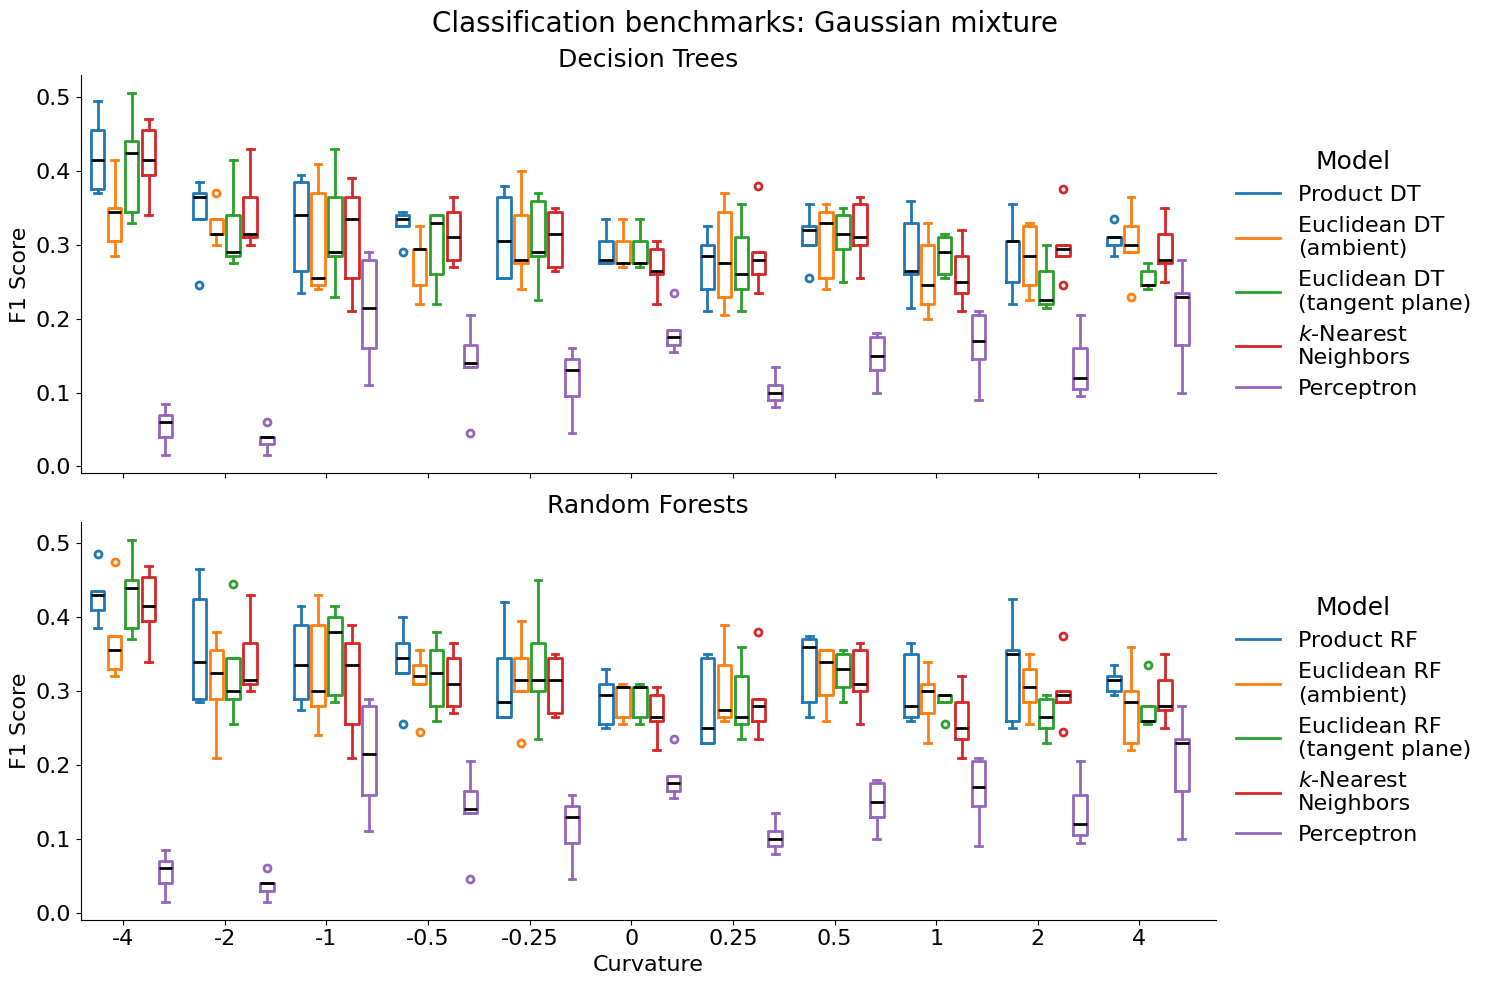

In [13]:
# Let's see the values: barplot with statistical significance annotations
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import wilcoxon

SIGNIFICANCE = "sig"
# SIGNIFICANCE = "ns"
CORRECTION = "bonferroni"
# CORRECTION = "none"

Y_LABEL = "F1 Score" if TASK == "classification" else "Root Mean Squared Error"


def test(x, y):
    # Check x and y are identical
    all_same = True
    for a, b in zip(x, y):
        if a != b:
            all_same = False
            break
    if all_same:
        return 1.0
    else:
        return wilcoxon(x, y).pvalue


# All the spec happens up here
models1 = ["product_dt", "sklearn_dt", "tangent_dt"]
model_names1 = ["Product DT", "Euclidean DT\n(ambient)", "Euclidean DT\n(tangent plane)"]
models2 = ["product_rf", "sklearn_rf", "tangent_rf"]
model_names2 = ["Product RF", "Euclidean RF\n(ambient)", "Euclidean RF\n(tangent plane)"]
# models3 = ["knn", "perceptron", "svm"]
# model_names3 = ["k-Nearest Neighbors", "Perceptron", "Support Vector Classifier"]
models3 = ["knn", "ps_perceptron"]
model_names3 = ["$k$-Nearest\nNeighbors", "Perceptron"]
colors = [f"C{i}" for i in range(len(models1 + models3))]

# Critical p-value depends on false discovery correction
CRITICAL_VAL = 0.05
if CORRECTION == "bonferroni":
    CRITICAL_VAL /= len(models1 + models3) * (len(models1 + models3) - 1) / 2

# Initialize plot
fig, axs = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
x_vals = np.arange(len(CURVATURES)) * (len(models1 + models3) + 1)

for ax, models, model_names in zip(
    axs, [models1 + models3, models2 + models3], [model_names1 + model_names3, model_names2 + model_names3]
):
    bps = []
    for i, (model, color) in enumerate(zip(models, colors)):
        # Initial boxplot
        bp = ax.boxplot(
            [results[results["curvature"] == K][model] for K in CURVATURES],
            positions=x_vals + i,
            widths=0.8,
            boxprops=dict(color=color, linewidth=2),
        )

        # Fix colors
        for element in ["boxes", "whiskers", "fliers", "means", "caps"]:
            plt.setp(bp[element], color=color, linewidth=2)
        plt.setp(bp["medians"], color="black", linewidth=2)
        plt.setp(bp["fliers"], marker="o", markersize=5, markeredgecolor=color, markeredgewidth=2)

        bps.append(bp)

    # # Flip y-axis for RMSE
    # if TASK == "regression":
    #     ax.invert_yaxis()

    # Add p-value annotations. All start at x_vals, and end at x_vals + i
    heights = [0] * len(CURVATURES)  # How many annotations per curvature
    # for i, j in [(0, 1), (1, 2), (0, 2), (0, 3), (1, 3), (2, 3)]:
    for i in range(len(models)):
        for j in range(i + 1, len(models)):
            results_K = [results[results["curvature"] == K] for K in CURVATURES]
            p_vals = [test(res[models[i]], res[models[j]]) for res in results_K]
            ymin, ymax = ax.get_ylim()
            em = ymax - ymin

            for k, p_val in enumerate(p_vals):
                if (SIGNIFICANCE == "ns" and p_val > CRITICAL_VAL) or (SIGNIFICANCE == "sig" and p_val < CRITICAL_VAL):
                    x1, x2 = x_vals[k] + i, x_vals[k] + j
                    height = results[results["curvature"] == CURVATURES[k]][models].max().max() + 0.04 * em * (
                        heights[k] + 1
                    )
                    annotation = "*" if SIGNIFICANCE == "sig" else "ns"
                    ax.text(
                        s=annotation,
                        x=(x1 + x2) / 2,
                        y=height,
                        ha="center",
                        va="center",
                        color="black",
                        fontdict={"weight": "bold"},
                    )
                    ax.plot(
                        [x1, x1, x2, x2],
                        [height - 0.02 * em, height - 0.01 * em, height - 0.01 * em, height - 0.02 * em],
                        lw=2,
                        color="black",
                    )
                    heights[k] += 1

    # Fix y-lim and remove top/right spines; make background transparent
    ax.patch.set_alpha(0)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # Set x-ticks
    ax.set_ylabel(Y_LABEL, fontsize=16)
    ax.set_xticks(x_vals + 1.5, CURVATURES, fontsize=16)
    # ax.legend([bp["boxes"][0] for bp in bps], model_names, fontsize=14, frameon=False, title="Model")
    # Make legend to the right of the plot
    ax.legend(
        [bp["boxes"][0] for bp in bps],
        model_names,
        fontsize=16,
        frameon=False,
        title="Model",
        title_fontsize=18,
        loc="center left",
        bbox_to_anchor=(1, 0.5),
    )
    ax.tick_params(axis="y", labelsize=16)
    # ax.set_yscale("log") if TASK == "regression" else None

axs[0].set_title("Decision Trees", fontsize=18)
axs[1].set_title("Random Forests", fontsize=18)
axs[1].set_xlabel("Curvature", fontsize=16)

plt.xlim(-1, len(CURVATURES) * (len(models1 + models3) + 1))
plt.suptitle(f"{TASK.capitalize()} benchmarks: Gaussian mixture", fontsize=20)

plt.tight_layout()

# Save as pdf
plt.savefig(
    f"../figures/curvature_benchmarks_{TASK}_md{MAX_DEPTH}_d{DIM}_cls{N_CLASSES}.pdf",
    bbox_inches="tight",
)
plt.show()

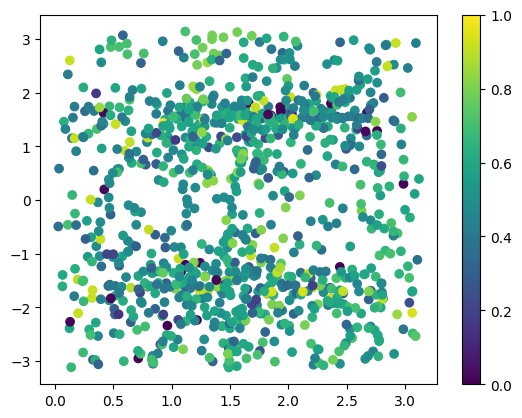

In [32]:
X_transformed = embedders.visualization.S2_to_polar(X).detach().cpu().numpy()
plt.scatter(X_transformed[:, 0], X_transformed[:, 1], c=y.detach().cpu().numpy())
plt.colorbar()

# HyperDT benchmark - by signature

In [14]:
SIGNATURES = [
    [(-1, 10)],
    [(0, 10)],
    [(1, 10)],
    [(-1, 5), (-1, 5)],
    [(1, 5), (1, 5)],
    [(-1, 5), (1, 5)],
    [(-1, 2), (-1, 2), (-1, 2), (-1, 2), (-1, 2)],
    [(1, 2), (1, 2), (1, 2), (1, 2), (1, 2)],
    [(-1, 2), (-1, 2), (0, 2), (1, 2), (1, 2)],
]

SIGNATURES_STR = [
    "H(-1, 10)",
    "E(0, 10)",
    "S(1, 10)",
    "H(-1, 5)^2",
    "S(1, 5)^2",
    "H(-1, 5) x \n S(1, 5)",
    "H(-1, 2)^5",
    "S(1, 2)^5",
    "H(-1, 2)^2 x \nE(0, 2) x \n S(1, 2)^2",
]

SIGNATURES_LATEX = [
    "\\H{10}",
    "\\E{10}",
    "\\S{10}",
    "(\\H{5})^2",
    "(\\S{5})^2",
    "\\H{5} \\times \\S{5}",
    "(\\H{2})^5",
    "(\\S{2})^5",
    "(\\H{2})^2 \\times \\E{2} \\times \\S{2}",
]

# SIGNATURES = [
#     [(-1, 10)],
#     [(0, 10)],
#     [(1, 10)],
#     # [(-1, 5), (-1, 5)],
#     [(-1, 5), (-2, 5)],
#     # [(1, 5), (1, 5)],
#     [(1, 5), (2, 5)],
#     # [(-1, 5), (1, 5)],
#     [(-1, 5), (2, 5)],
#     [(-2, 5), (1, 5)],
#     # [(-1, 2), (-1, 2), (-1, 2), (-1, 2), (-1, 2)],
#     [(-.25, 2), (-.5, 2), (-1, 2), (-2, 2), (-4, 2)],
#     # [(1, 2), (1, 2), (1, 2), (1, 2), (1, 2)],
#     [(.25, 2), (.5, 2), (1, 2), (2, 2), (4, 2)],
#     # [(-1, 2), (-1, 2), (0, 2), (1, 2), (1, 2)],
#     [(-1, 2), (-2, 2), (0, 2), (2, 2), (4, 2)],
# ]

# SIGNATURES_STR = [
#     "H(-1, 10)",
#     "E(0, 10)",
#     "S(1, 10)",
#     # "H(-1, 5)^2",
#     "H(-1, 5) x \n H(-2, 5)",
#     # "S(1, 5)^2",
#     "S(1, 5) x \n S(2, 5)",
#     # "H(-1, 5) x \n S(1, 5)",
#     "H(-1, 5) x \n S(2, 5)",
#     "H(-2, 5) x \n S(1, 5)",
#     # "H(-1, 2)^5",
#     "H(-0.25, 2) x \nH(-0.5, 2) x \nH(-1, 2) x \nH(-2, 2) x \nH(-4, 2)",
#     # "S(1, 2)^5",
#     "S(0.25, 2) x \nS(0.5, 2) x \nS(1, 2) x \nS(2, 2) x \nS(4, 2)",
#     # "H(-1, 2)^2 x \nE(0, 2) x \n S(1, 2)^2",
#     "H(-1, 2) x \nH(-2, 2) x \nE(0, 2) x \nS(2, 2) x \nS(4, 2)",
# ]

# SIGNATURES_LATEX = [
#     "\\H{10}",
#     "\\E{10}",
#     "\\S{10}",
#     "(\\H{5}{-1}) \\times (\\H{5}{-2})",
#     "(\\S{5}{-1}) \\times (\\S{5}{-2})",
#     "\\H{5}{-1} \\times \\S{5}{-2}",
#     "\\H{5}{-2} \\times \\S{5}{-1}",
#     "(\\H{2}{-.25}) \\times (\\H{2}{-.5}) \\times (\\H{2}{-1}) \\times (\\H{2}{-2}) \\times (\\H{2}{-4})",
#     "(\\S{2}{.25}) \\times (\\S{2}{.5}) \\times (\\S{2}{1}) \\times (\\S{2}{2}) \\times (\\S{2}{4})",
#     "(\\H{2}{-1} \\times \\h{2}{-2} \\times \\E{2} \\times \\S{2}{2} \\times \\S{2}{4})",
# ]

In [33]:
# Non-Gu signature selection
SIGNATURES = [
    [(-1, 2), (-1, 2)],
    [(-1, 2), (0, 2)],
    [(-1, 2), (1, 2)],
    [(0, 4)],
    [(1, 2), (1, 2)],
    [(-1, 2), (-1, 2), (-1, 2)],
    [(-1, 2), (-1, 2), (0, 2)],
    [(-1, 2), (0, 4)],
    [(0, 4), (1, 2)],
    [(0, 2), (1, 2), (1, 2)],
    [(1, 2), (1, 2), (1, 2)],
    [(-1, 2), (-1, 2), (1, 2)],
    [(-1, 2), (1, 2), (1, 2)],
    [(-1, 2), (0, 2), (1, 2)],
]

SIGNATURES_STR = [
    "H(-1, 2)^2",
    "H(-1, 2) x E(0, 2)",
    "H(-1, 2) x S(1, 2)",
    "E(0, 4)",
    "S(1, 2)^2",
    "H(-1, 2)^3",
    "H(-1, 2)^2 x E(0, 2)",
    "H(-1, 2) x E(0, 4)",
    "E(0, 4) x S(1, 2)",
    "E(0, 2) x S(1, 2)^2",
    "S(1, 2)^3",
    "H(-1, 2)^2 x S(1, 2)",
    "H(-1, 2) x S(1, 2)^2",
    "H(-1, 2) x E(0, 2) x S(1, 2)",
]

SIGNATURES_LATEX = [
    "(\\H{2})^2",
    "\\H{2} \\times \\E{2}",
    "\\H{2} \\times \\S{2}",
    "\\E{4}",
    "(\\S{2})^2",
    "(\\H{2})^3",
    "(\\H{2})^2 \\times \\E{2}",
    "\\H{2} \\times \\E{4}",
    "\\E{4} \\times \\S{2}",
    "\\E{2} \\times (\\S{2})^2",
    "(\\S{2})^3",
    "(\\H{2})^2 \\times \\S{2}",
    "\\H{2} \\times (\\S{2})^2",
    "\\H{2} \\times \\E{2} \\times \\S{2}",
]

In [35]:
from tqdm.notebook import tqdm

import pandas as pd
import embedders

# Suppress warnings
import warnings

warnings.filterwarnings("ignore")

results2 = []

N_POINTS = 1_000
N_TRIALS = 100
N_CLASSES = 8
N_CLUSTERS = 32
COV_SCALE_MEANS = 1.0
COV_SCALE_POINTS = 0.1
MAX_DEPTH = 5
# RESAMPLE_SCALES = True
RESAMPLE_SCALES = False
# TASK = "classification"
# METRIC = "f1-micro"
# METRIC = "accuracy"
TASK = "regression"
METRIC = "rmse"


my_tqdm = tqdm(total=len(SIGNATURES) * N_TRIALS)
for i, signature in enumerate(SIGNATURES):
    for seed in range(N_TRIALS):
        # Ensure unique seed per trial
        seed = seed + N_TRIALS * i
        pm = embedders.manifolds.ProductManifold(signature=signature)

        # Get X, y
        X, y = embedders.gaussian_mixture.gaussian_mixture(
            pm=pm,
            seed=seed,
            num_points=N_POINTS,
            num_classes=N_CLASSES,
            num_clusters=N_CLUSTERS,
            cov_scale_means=COV_SCALE_MEANS / pm.dim,
            cov_scale_points=COV_SCALE_POINTS / pm.dim,
            task=TASK,
        )

        # Scale is a random integer from 0 to 1
        if RESAMPLE_SCALES:
            for M in pm.P:
                scale = 0.5 - np.random.rand() * 20
                M.scale = torch.exp(torch.tensor(scale)).item()
                M.manifold._log_scale = torch.nn.Parameter(torch.tensor(scale))

        accs = embedders.benchmarks.benchmark(X, y, pm, max_depth=MAX_DEPTH, score=METRIC, task=TASK)
        accs["signature"] = SIGNATURES_STR[i]
        accs["seed"] = seed
        results2.append(accs)

        my_tqdm.update(1)

results2 = pd.DataFrame(results2)

  0%|          | 0/1400 [00:00<?, ?it/s]

In [36]:
# Turn table into 95% confidence intervals with p-values
import numpy as np

models = models1 + models2 + models3
model_names = ["Prod. DT", "Euc. DT", "Tan. DT", "Prod. RF", "Euc. RF", "Tan. RF", "k-NN"]
model_colors = ["product_dt", "euclidean_dt", "tangent_dt", "product_dt", "euclidean_dt", "tangent_dt", "knn"]

# start_str = """
# \\begin{tabular}{cccccccc}
#     \\toprule
#                 & Product space & Euclidean     & Tangent plane & Product space & Euclidean     & Tangent plane\\\\
#     Signature   & decision tree & decision tree & decision tree & random forest & random forest & random forest\\\\
#     \\hline
# """
start_str = "\\begin{tabular}{"
start_str += "c" * (len(models) + 1)
start_str += "}\n"
start_str += "\\toprule\nSignature & "
# start_str += " & ".join([x.replace("_", "\_") for x in models])
start_str += " & ".join(["\col{" + col + "}{" + x + "}" for x, col in zip(model_names, model_colors)])
start_str += "\\\\\n\\hline" ""

# suffix = ""

print(start_str)
for signature, sigstr in zip(SIGNATURES_STR, SIGNATURES_LATEX):
    r = results2[results2["signature"] == signature]
    print(f"\t${sigstr}$", end="\t")
    for model in models:
        mean = r[model].mean()
        std = r[model].std()
        n = r[model].shape[0]
        ci = 1.96 * std / np.sqrt(n)
        if model != "knn":
            pre, post = model.split("_")[0], model.split("_")[1]
        else:
            post = "rf"
        asts = []
        _p, _e, _t = r[f"product_{post}"], r[f"sklearn_{post}"], r[f"tangent_{post}"]
        _k = r["knn"]
        reg = -1 if TASK == "regression" else 1  # Flip sign for regression
        if reg * mean > reg * _p.mean() and test(r[model], _p) < 0.05:
            asts.append("*")
        if reg * mean > reg * _e.mean() and test(r[model], _e) < 0.05:
            asts.append("\dagger")
        if reg * mean > reg * _t.mean() and test(r[model], _t) < 0.05:
            asts.append("\ddagger")
        if reg * mean > reg * _k.mean() and test(r[model], _k) < 0.05:
            asts.append("\mathsection")  # Not \S because we override that
        if asts:
            asts = "^{" + "".join(asts) + "}"
        else:
            asts = ""
        # if np.round(mean, 3) == max([np.round(x.mean(), 3) for x in [_p, _e, _t]]):
        if (TASK == "classification" and np.round(mean, 3) == max([np.round(r[x].mean(), 3) for x in models])) or (
            TASK == "regression" and np.round(mean, 3) == min([np.round(r[x].mean(), 3) for x in models])
        ):
            print("& $\mathbf{" + f"{mean*100:.1f} \pm {ci*100:.1f}{asts}" + "}$", end="\t")
        else:
            print(f"& ${mean*100:.1f} \pm {ci*100:.1f}{asts}$", end="\t")
    print("\\\\")
end_str = """
    \\bottomrule
\\end{tabular}
"""
print(end_str)

\begin{tabular}{cccccccc}
\toprule
Signature & \col{product_dt}{Prod. DT} & \col{euclidean_dt}{Euc. DT} & \col{tangent_dt}{Tan. DT} & \col{product_dt}{Prod. RF} & \col{euclidean_dt}{Euc. RF} & \col{tangent_dt}{Tan. RF} & \col{knn}{k-NN}\\
\hline
	$(\H{2})^2$	& $18.0 \pm 0.5$	& $18.0 \pm 0.5$	& $17.9 \pm 0.5$	& $17.5 \pm 0.5$	& $16.4 \pm 0.5^{*}$	& $16.3 \pm 0.5^{*}$	& $\mathbf{13.8 \pm 0.5^{*\dagger\ddagger}}$	\\
	$\H{2} \times \E{2}$	& $18.6 \pm 0.5^{\dagger\ddagger}$	& $18.9 \pm 0.5$	& $18.9 \pm 0.5$	& $18.0 \pm 0.5$	& $17.1 \pm 0.5^{*}$	& $17.1 \pm 0.5^{*}$	& $\mathbf{14.5 \pm 0.5^{*\dagger\ddagger}}$	\\
	$\H{2} \times \S{2}$	& $18.3 \pm 0.6$	& $18.3 \pm 0.6$	& $18.1 \pm 0.5$	& $17.6 \pm 0.5$	& $16.4 \pm 0.5^{*\ddagger}$	& $16.5 \pm 0.5^{*}$	& $\mathbf{13.9 \pm 0.5^{*\dagger\ddagger}}$	\\
	$\E{4}$	& $20.2 \pm 0.6$	& $20.1 \pm 0.6$	& $20.2 \pm 0.6$	& $20.0 \pm 0.5$	& $18.5 \pm 0.5^{*}$	& $18.5 \pm 0.5^{*}$	& $\mathbf{16.9 \pm 0.6^{*\dagger\ddagger}}$	\\
	$(\S{2})^2$	& $18.5 \pm 0.6$	

In [18]:
# Transposed version

import numpy as np
from scipy.stats import ttest_rel

# Combine all models
models = models1 + models2 + models3
# models = [m for m in models if m not in ["knn"]]

# Start string
start_str = "\\begin{tabular}{"
start_str += "c" * (len(SIGNATURES_LATEX) + 1)
start_str += "}\n"
start_str += "\\toprule\nMetric & "
start_str += " & ".join([f"${latex}$" for latex in SIGNATURES_LATEX])
start_str += "\\\\\n\\hline\n"

print(start_str)

for model, model_name, col in zip(models, model_names, model_colors):
    # print(model.replace("_", "\\_"), end=" & ")
    print(f"\col{{{col}}}{{{model_name}}}", end=" & ")

    model_results = []
    for signature, sigstr in zip(SIGNATURES_STR, SIGNATURES_LATEX):
        r = results2[results2["signature"] == signature]
        mean = r[model].mean()
        std = r[model].std()
        n = r[model].shape[0]
        ci = 1.96 * std / np.sqrt(n)

        asts = []
        # Uncomment and modify these lines if you want to implement the asterisk logic
        # if mean > r["product_space"].mean() and ttest_rel(r[model], r["product_space"]).pvalue < 0.05:
        #     asts.append("*")
        # if mean > r["euclidean"].mean() and ttest_rel(r[model], r["euclidean"]).pvalue < 0.05:
        #     asts.append("\dagger")
        # if mean > r["tangent_plane"].mean() and ttest_rel(r[model], r["tangent_plane"]).pvalue < 0.05:
        #     asts.append("\ddagger")

        if asts:
            asts = "^{" + "".join(asts) + "}"
        else:
            asts = ""

        if (TASK == "classification" and np.round(mean, 3) == max([np.round(r[x].mean(), 3) for x in models])) or (
            TASK == "regression" and np.round(mean, 3) == min([np.round(r[x].mean(), 3) for x in models])
        ):
            cell = f"$\\mathbf{{{mean*100:.1f} \\pm {ci*100:.1f}{asts}}}$"
        else:
            cell = f"${mean*100:.1f} \\pm {ci*100:.1f}{asts}$"

        model_results.append(cell)

    print(" & ".join(model_results) + " \\\\")

end_str = """
\\bottomrule
\\end{tabular}
"""
print(end_str)

\begin{tabular}{ccccccccccccccc}
\toprule
Metric & $(\H{2})^2$ & $\H{2} \times \E{2}$ & $\H{2} \times \S{2}$ & $\E{4}$ & $(\S{2})^2$ & $(\H{2})^3$ & $(\H{2})^2 \times \E{2}$ & $\H{2} \times \E{4}$ & $\E{4} \times \S{2}$ & $\E{2} \times (\S{2})^2$ & $(\S{2})^3$ & $(\H{2})^2 \times \S{2}$ & $\H{2} \times (\S{2})^2$ & $\H{2} \times \E{2} \times \S{2}$\\
\hline

\col{product_dt}{Prod. DT} & $58.8 \pm 4.4$ & $55.8 \pm 4.3$ & $56.6 \pm 3.8$ & $49.1 \pm 4.5$ & $54.1 \pm 3.5$ & $64.8 \pm 6.4$ & $61.7 \pm 5.0$ & $55.8 \pm 4.8$ & $56.9 \pm 3.8$ & $62.4 \pm 4.1$ & $61.0 \pm 4.1$ & $61.1 \pm 3.4$ & $57.5 \pm 5.3$ & $61.2 \pm 2.4$ \\
\col{euclidean_dt}{Euc. DT} & $59.4 \pm 3.9$ & $54.4 \pm 3.8$ & $58.0 \pm 3.6$ & $49.1 \pm 4.4$ & $52.8 \pm 5.3$ & $66.3 \pm 3.3$ & $60.5 \pm 5.2$ & $55.4 \pm 4.1$ & $57.5 \pm 4.4$ & $62.6 \pm 3.2$ & $61.4 \pm 3.1$ & $61.0 \pm 2.3$ & $58.1 \pm 6.5$ & $62.2 \pm 3.1$ \\
\col{tangent_dt}{Tan. DT} & $59.7 \pm 3.8$ & $55.7 \pm 3.8$ & $56.4 \pm 5.3$ & $49.2 \pm 4.4$ & $52.0 